In [803]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose, STL
# from geopy.geocoders import Nominatim

from tqdm import tqdm

In [804]:
df = pd.read_pickle("train.pkl")
df_test = pd.read_pickle("test.pkl")

df.rename(columns={"PM2.5_target": "y"}, inplace=True)
df_test.rename(columns={"PM2.5_target": "y"}, inplace=True)
df.rename(columns={c: c.replace(" ", "_") for c in df.columns}, inplace=True)
df_test.rename(columns={c: c.replace(" ", "_") for c in df_test.columns}, inplace=True)

In [805]:
# Add year, month, day, hour columns (as dummies)
df["year"] = df.index.get_level_values("date").year
df["month"] = df.index.get_level_values("date").month
df["day"] = df.index.get_level_values("date").day
df["hour"] = df.index.get_level_values("date").hour

df = pd.get_dummies(df, columns=["month", "day", "hour"], drop_first=True)

# Drop columns with only NaNs
df.dropna(axis=1, how="all", inplace=True)


# # Add year, month, day, hour columns (as dummies)
# df_test["year"] = df_test.index.get_level_values("date").year
# df_test["month"] = df_test.index.get_level_values("date").month
# df_test["day"] = df_test.index.get_level_values("date").day
# df_test["hour"] = df_test.index.get_level_values("date").hour

# df_test = pd.get_dummies(df_test, columns=["month", "day", "hour"], drop_first=True)

In [806]:
# Keep only data from 2018 onwards
df = df.loc[df.index.get_level_values("date") >= "2018-01-01"]

# Redefine test / true
df_test = df.loc[df.index.get_level_values("date") >= "2021-04-01"].copy()
df = df.loc[df.index.get_level_values("date") < "2021-04-01"].copy()

In [811]:
class ModelEvaluation:
    def __init__(self, test_full, y_col="y"):
        test_full = test_full.sort_index(level=["date", "city"])
        self.index = test_full.index
        self.y = test_full[y_col].values

    def compare(self, y_pred):
        y_pred = y_pred.sort_index(level=["date", "city"])
        
        if np.any(y_pred.index != self.index):
            raise ValueError("Indices do not match")
        
        if y_pred.shape != self.y.shape:
            raise ValueError("Shapes do not match")
        
        
        losses = pd.DataFrame({"loss": (y_pred - self.y) ** 2}, index=self.index)
        total = losses["loss"].mean()
        return pd.concat([losses.groupby("city").mean(), 
                          pd.DataFrame({"loss": total}, index=["All"])])

In [813]:
results = []

In [814]:
# Predict using mean of all train data
df_test["y"] = df["y"].mean()

meval.compare(df_test["y"])

,loss
Agra,5429.688227
Ahmedabad,1523.643360
Bengaluru,2560.966966
Chennai,3087.826349
Delhi,8269.548319
Hyderabad,2457.430640
Kanpur,3288.652046
Kolkata,2199.211131
Lucknow,2501.396410
Mumbai,2062.667914


In [815]:
# Predict using mean of logs of all train data
df_test["y"] = np.exp(np.log(df["y"]).mean())

meval.compare(df_test["y"])

,loss
Agra,5646.034846
Ahmedabad,720.702537
Bengaluru,880.215932
Chennai,1198.096536
Delhi,9577.699547
Hyderabad,994.471867
Kanpur,2868.545556
Kolkata,1216.064405
Lucknow,2300.179302
Mumbai,838.812595


In [816]:
# Past means by city
dfg = df.groupby("city").y.mean()
mapping = {city: dfg[city] for city in dfg.index}
df_test["y"] = df_test.index.get_level_values("city").map(lambda x: mapping[x])

meval.compare(df_test["y"])

,loss
Agra,5774.999397
Ahmedabad,938.582550
Bengaluru,338.426863
Chennai,737.686994
Delhi,8324.913779
Hyderabad,711.689308
Kanpur,4875.674817
Kolkata,1663.304201
Lucknow,4330.385836
Mumbai,638.737788


In [817]:
df["logy"] = np.log(df.y)

In [818]:
# Past means of logs by city
dfg = df.groupby("city").logy.mean()
mapping = {city: np.exp(dfg[city]) for city in dfg.index}
df_test["y"] = df_test.index.get_level_values("city").map(lambda x: mapping[x])

meval.compare(df_test["y"])

,loss
Agra,5381.461364
Ahmedabad,710.335213
Bengaluru,299.658375
Chennai,508.919150
Delhi,8137.932829
Hyderabad,622.609682
Kanpur,3014.084294
Kolkata,1130.394814
Lucknow,2707.241814
Mumbai,711.839725


In [819]:
# Missing values per column
df.isna().mean().sort_values(ascending=False)

THC       0.963641
HCHO      0.944002
Hg        0.942861
MH        0.936991
CH4       0.817009
            ...   
day_5     0.000000
day_4     0.000000
day_3     0.000000
day_2     0.000000
day_10    0.000000
Length: 97, dtype: float64

In [820]:
df.isna().mean().sort_values(ascending=False) 

THC       0.963641
HCHO      0.944002
Hg        0.942861
MH        0.936991
CH4       0.817009
            ...   
day_5     0.000000
day_4     0.000000
day_3     0.000000
day_2     0.000000
day_10    0.000000
Length: 97, dtype: float64

In [821]:
# # Add year, month, day, hour columns (as dummies)
# df["year"] = df.index.get_level_values("date").year
# df["month"] = df.index.get_level_values("date").month
# df["day"] = df.index.get_level_values("date").day
# df["hour"] = df.index.get_level_values("date").hour

# df = pd.get_dummies(df, columns=["month", "day", "hour"], drop_first=True)

# # Add year, month, day, hour columns (as dummies)
# df_test["year"] = df_test.index.get_level_values("date").year
# df_test["month"] = df_test.index.get_level_values("date").month
# df_test["day"] = df_test.index.get_level_values("date").day
# df_test["hour"] = df_test.index.get_level_values("date").hour

# df_test = pd.get_dummies(df_test, columns=["month", "day", "hour"], drop_first=True)

In [822]:
from lightgbm import LGBMRegressor

In [823]:
# Iteratively, fill features using LightGBM trained on all features that have no NaNs
features = df.drop(columns=["y", "PM2.5", "logy"]).isna().mean().sort_values()
features_full = features[features == 0].index.tolist()
features_to_impute = features[features > 0].index.tolist()

In [824]:
for feature in tqdm(features_to_impute, total=len(features_to_impute)):
    # Make LGBM data
    X = df[features_full]
    X_test = df_test[features_full]
    y = df[feature]

    # Train LGBM
    lgbm = LGBMRegressor(verbose=0, n_jobs=-1).fit(X, y)
    y_pred = lgbm.predict(X)
    y_pred_test = lgbm.predict(X_test)

    # Fill NaNs
    df[feature].fillna(pd.Series(y_pred, index=df.index), inplace=True)
    df_test[feature].fillna(pd.Series(y_pred_test, index=df_test.index), inplace=True)

    # We can now use this feature for imputing other features
    features_full.append(feature)

100%|██████████| 27/27 [00:25<00:00,  1.07it/s]


In [825]:
# Replace NaNs from y in a very non-sophisticated way
df.y.fillna(df.y.mean(), inplace=True)
df.logy = np.log(df.y)

In [826]:
from sklearn.linear_model import LinearRegression

In [827]:
features = [c for c in df.columns if c not in ["y", "PM2.5", "logy"]]
out1 = ["y"]
out2 = ["logy"]

In [828]:
# Linear regression on all features
X = df[features]
features = X.columns.tolist()
y = df[out1]

ols = LinearRegression().fit(X, y)

y_pred = ols.predict(df_test[features])
meval.compare(pd.DataFrame(y_pred, index=df_test.index, columns=["y"])["y"])

,loss
Agra,3085.998468
Ahmedabad,1141.423081
Bengaluru,951.395782
Chennai,852.677924
Delhi,2568.258359
Hyderabad,445.103605
Kanpur,2193.242798
Kolkata,513.827201
Lucknow,1648.992897
Mumbai,459.755594


In [829]:
# Linear regression on all features but log output
X = df[features]
features = X.columns.tolist()
y = df[out2]

ols = LinearRegression().fit(X, y)

y_pred = np.exp(ols.predict(df_test[features]))
meval.compare(pd.DataFrame(y_pred, index=df_test.index, columns=["y"])["y"])

,loss
Agra,3363.870080
Ahmedabad,562.532243
Bengaluru,235.432143
Chennai,336.810324
Delhi,2534.145712
Hyderabad,248.542677
Kanpur,1538.837756
Kolkata,379.160340
Lucknow,1013.576806
Mumbai,249.326675


In [830]:
# LightGBM on all features
lgbm = LGBMRegressor(verbose=0).fit(X, df[out1])
y_pred = lgbm.predict(df_test[features])
meval.compare(pd.DataFrame(y_pred, index=df_test.index, columns=["y"])["y"])

,loss
Agra,2543.378051
Ahmedabad,494.152069
Bengaluru,251.985900
Chennai,453.317575
Delhi,1263.904541
Hyderabad,338.280371
Kanpur,3207.139901
Kolkata,279.236161
Lucknow,3133.967181
Mumbai,249.200316


In [831]:
# LightGBM on all features
lgbm = LGBMRegressor(verbose=0).fit(X, df[out2])
y_pred = np.exp(lgbm.predict(df_test[features]))
meval.compare(pd.DataFrame(y_pred, index=df_test.index, columns=["y"])["y"])

,loss
Agra,2617.444075
Ahmedabad,446.399289
Bengaluru,189.571959
Chennai,321.450097
Delhi,1474.152898
Hyderabad,171.968787
Kanpur,2319.610260
Kolkata,251.930918
Lucknow,2032.375033
Mumbai,161.734649


In [832]:
# What if instead, we use the contemporaneous values of other cities to help in prediction?
# Transform dataframe to wide format, using index level city
df_test["y"] = meval.y.copy()
df_test["logy"] = np.log(df_test["y"])

df_wide = df.reset_index().pivot(index="date", columns="city", values=features + out1 + out2)
df_wide.columns = df_wide.columns.map('_'.join).str.strip('_')
df_wide_test = df_test.reset_index().pivot(index="date", columns="city", values=features + out1 + out2)
df_wide_test.columns = df_wide_test.columns.map('_'.join).str.strip('_')

features = [c for c in df_wide.columns if not (c.startswith("y_") or c.startswith("logy_"))]

In [833]:
df_wide = df_wide.astype(float)
df_wide_test = df_wide_test.astype(float)

In [834]:
cities = sorted(df.index.get_level_values("city").unique().to_list())
out1 = ["y_" + city for city in cities]
out2 = ["logy_" + city for city in cities]

In [835]:
pred = pd.DataFrame(index=df_test.index, columns=["y"])

In [836]:
for city in tqdm(cities, total=len(cities), unit="city", desc="Fitting models"):
    # Train LGBM
    lgbm = LGBMRegressor(verbose=0).fit(df_wide[features], df_wide[f"logy_{city}"])
    y_pred = lgbm.predict(df_wide_test[features])
    pred.loc[pred.index.get_level_values("city") == city, "y"] = np.exp(y_pred)

meval.compare(pred["y"])

Fitting models: 100%|██████████| 12/12 [00:14<00:00,  1.21s/city]


,loss
Agra,3043.685075
Ahmedabad,401.451925
Bengaluru,190.874502
Chennai,302.468498
Delhi,1386.074424
Hyderabad,173.918395
Kanpur,1620.365897
Kolkata,218.273452
Lucknow,802.302701
Mumbai,180.336749


In [981]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from torch.utils.data import Dataset, DataLoader

In [982]:
class SimpleLSTM(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs=1, num_lstm_layers=2):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs

        self.lstm = nn.LSTM(n_inputs, n_hidden, num_lstm_layers, batch_first=True)
        self.dense = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(n_hidden, n_hidden),
            # nn.ReLU(),
            # nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_outputs)
        )

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dense(x)
        return x

In [983]:
class PMDataset(Dataset):
    # We could also define our constructor to take a pandas dataframe and extract the 
    # features / targets directly. Notice that we must also specify a sequence length
    def __init__(self, X, y, seq_len, enforce_shape=False):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)
        self.added = 0
        # We need the Tensors to be of a length divisible by the sequence length
        if enforce_shape and (X.shape[0] % seq_len != 0):
            # Pad with zeros
            self.X = torch.cat([self.X, torch.zeros(seq_len - X.shape[0] % seq_len, *self.X.shape[1:])])
            self.y = torch.cat([self.y, torch.zeros(seq_len - y.shape[0] % seq_len, *self.y.shape[1:])])
            self.added = seq_len - X.shape[0] % seq_len
        self.seq_len = seq_len

    def __len__(self):
        return (self.y.shape[0] - self.seq_len) // self.seq_len + 1
    
    def __getitem__(self, idx):
        idx *= self.seq_len
        return self.X[idx:idx+self.seq_len], self.y[idx:idx+self.seq_len]

In [1059]:
from sklearn.preprocessing import StandardScaler

In [1064]:
def make_lstm_preds(df_train, df_test, batch_size=128, seq_len=96, n_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
    # Use mean-square error as a loss
    loss_fn = nn.MSELoss()

    preds = {}

    
    for city in tqdm(cities, total=len(cities), unit="city", desc="Fitting models"):
        dfx = df_train.xs(city, level="city").copy()
        dfy = df_test.xs(city, level="city").copy()
        dfx.ffill(inplace=True)
        dfy.ffill(inplace=True)

        X_train = dfx.drop(columns=["y", "PM2.5", "logy"])
        y_train = dfx["logy"].values.reshape(-1, 1)

        X_test = dfy.drop(columns=["y", "PM2.5", "logy"])
        y_test = dfy["logy"].values.reshape(-1, 1)

        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        dsx = PMDataset(X=X_train, y=y_train, seq_len=seq_len)
        dsy = PMDataset(X=X_test, y=y_test, seq_len=seq_len, enforce_shape=True)
        dlx = DataLoader(dsx, batch_size=batch_size, shuffle=True)
        dly = DataLoader(dsy, batch_size=1, shuffle=False)

        nnet = SimpleLSTM(X_train.shape[1], 128, 1).to(device)

        opt = optim.Adam(nnet.parameters(), lr=1e-4)
        sched = lr_scheduler.OneCycleLR(opt, max_lr=0.01, 
                                        steps_per_epoch=len(dlx), 
                                        epochs=n_epochs) 

        for epoch in range(n_epochs):
            nnet.train()

            for X, y in dlx:
                # Pass the batch to the GPU
                X = X.to(device)
                y = y.to(device)

                # Reset the gradients
                opt.zero_grad()

                # Compute the forward pass
                y_pred = nnet(X)
                
                # Compute the loss
                loss = loss_fn(y, y_pred)

                # Compute the gradients
                loss.backward()

                # Update the parameters
                opt.step()
                sched.step()

        # Make predictions
        nnet.eval()
        y_pred = []
        with torch.no_grad():
            for X, y in dly:
                X = X.to(device)
                y_pred.append(nnet(X).cpu().numpy())

        y_pred = np.concatenate(y_pred).reshape(-1)[:-dsy.added]

        preds[city] = np.exp(y_pred)

    return preds

In [1065]:
preds = make_lstm_preds(df, df_test)
preds = pd.DataFrame(preds, index=df_test.index.get_level_values("date").unique())

Fitting models: 100%|██████████| 12/12 [00:12<00:00,  1.03s/city]


In [1066]:
df_preds = pd.melt(preds, ignore_index=False).rename(columns={"variable": "city", "value": "y"})
df_preds["date"] = df_preds.index
df_preds = df_preds.set_index(["date", "city"]).sort_index(level=[0, 1])

In [1067]:
meval.compare(df_preds["y"])

,loss
Agra,4986.985958
Ahmedabad,5510.946420
Bengaluru,226.999497
Chennai,506.035938
Delhi,1955.885491
Hyderabad,161.007388
Kanpur,2873.046097
Kolkata,264.071180
Lucknow,3001.634197
Mumbai,290.782229


In [1046]:
city = "Delhi"

In [1047]:
dfx = df.xs(city, level="city").copy()
dfy = df_test.xs(city, level="city").copy()
dfy.ffill(inplace=True) # Fill NaNs with last known value

In [1048]:
X_train = dfx.drop(columns=["y", "PM2.5", "logy"])
y_train = dfx["logy"].values.reshape(-1, 1)

X_test = dfy.drop(columns=["y", "PM2.5", "logy"])
y_test = dfy["logy"].values.reshape(-1, 1)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [1049]:
ds = PMDataset(X=X_train, y=y_train, seq_len=96)
val_ds = PMDataset(X=X_test, y=y_test, seq_len=96, enforce_shape=True)

dl = DataLoader(ds, batch_size=128, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=False)

In [1050]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nnet = SimpleLSTM(X_train.shape[1], 128, 1).to(device)

In [1051]:
epochs = 50
# Use mean-square error as a loss
loss_fn = nn.MSELoss()

# Instantiate Adam optimizer with learning rate 0.0001<
opt = optim.Adam(nnet.parameters(), lr=1e-4)
sched = lr_scheduler.OneCycleLR(opt, max_lr=0.01, steps_per_epoch=len(dl), epochs=epochs)

In [1052]:
losses = np.zeros(epochs)
val_losses = np.zeros(epochs)
for epoch in tqdm(range(epochs), unit="epoch", desc="Fitting Model...", total=epochs):
    nnet.train()

    for X, y in dl:
        # Pass the batch to the GPU
        X = X.to(device)
        y = y.to(device)

        # Reset the gradients
        opt.zero_grad()

        # Compute the forward pass
        y_pred = nnet(X)
        
        # Compute the loss
        loss = loss_fn(y, y_pred)
        with torch.no_grad():
            loss_ = loss_fn(torch.exp(y), torch.exp(y_pred))
        
        # Compute the gradients
        loss.backward()

        # Update the parameters
        opt.step()
        sched.step()

        # Store the epoch average losses to plot later on
        losses[epoch] += loss_.detach().cpu().numpy() / y.shape[0]

    with torch.no_grad():
        nnet.eval()
        for X, y in val_dl:
            # Pass the batch to the GPU
            X = X.to(device)
            y = y.to(device)

            # Compute the forward pass
            y_pred = nnet(X)
            
            # Compute the loss
            loss = loss_fn(torch.exp(y), torch.exp(y_pred))

            # Store the epoch average losses to plot later on
            val_losses[epoch] += loss.detach().cpu().numpy() / y.shape[0]

    



Fitting Model...: 100%|██████████| 50/50 [00:00<00:00, 55.32epoch/s]


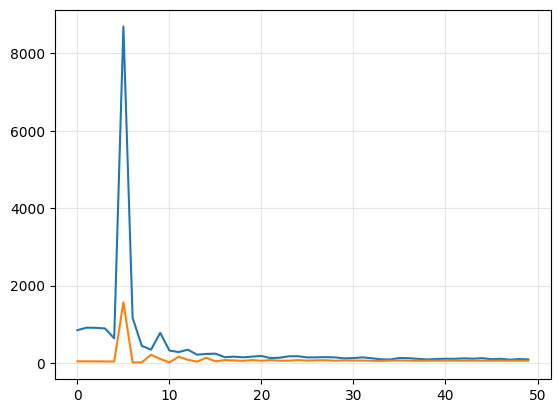

In [1053]:
fig, ax = plt.subplots()

ax.plot(losses[:50], label="Training Loss")
ax.plot(val_losses[:100], label="Validation Loss")
ax.grid(alpha=.3)

In [1054]:
nnet.eval()
ys = []
ys_pred = []
for X, y in val_dl:
    ys.append(y.detach().cpu().numpy())
    ys_pred.append(nnet(X.to(device)).detach().cpu().numpy())

In [1055]:
ys = np.concatenate([y.flatten() for y in ys])
preds = np.concatenate([y_pred.flatten() for y_pred in ys_pred])

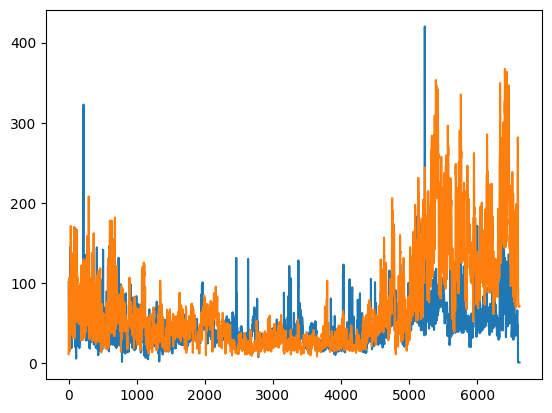

In [1056]:
plt.plot(np.exp(ys))
plt.plot(np.exp(preds))

In [1057]:
((np.exp(ys) - np.exp(preds)) ** 2).mean()

3776.8423

In [1058]:
val_losses

array([  38.92826512,   38.8358172 ,   38.58952177,   36.52345165,
         34.86622863, 1564.09714674,    9.41290106,   11.91538847,
        209.04037874,  102.39800583,   10.97718347,  157.04496433,
         79.60769786,   32.42358398,  132.40268342,   38.67554419,
         71.01152768,   62.55706522,   51.55682815,   72.50223619,
         53.23240772,   71.86875142,   53.94384412,   57.01431584,
         71.10286458,   56.64661883,   66.12207031,   65.95076851,
         53.60660807,   62.8518031 ,   57.74377618,   59.10189864,
         53.28671663,   49.34883449,   58.05833899,   61.74139493,
         55.26615928,   51.28910142,   53.74118971,   55.97891191,
         55.80097939,   55.03119339,   54.54856275,   54.21263233,
         54.32885035,   54.63047724,   54.75396286,   54.74657142,
         54.73780358,   54.73684471])

In [273]:
val_losses

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [142]:
losses

array([1.06422936, 1.03229261, 0.82521286, 0.799997  , 0.98873924,
       0.94004444, 1.05428016, 1.04951282, 1.04496835, 1.04380196])

In [143]:
y

tensor([[[3.8177, 3.3510, 3.0473,  ..., 2.6214, 2.9390, 2.4849],
         [3.7842, 3.4855, 3.0986,  ..., 2.7877, 2.9964, 3.4012],
         [3.6951, 3.5392, 3.2024,  ..., 2.8056, 3.1218, 3.7899],
         ...,
         [3.4095, 3.4788, 2.8215,  ..., 2.8888, 3.9935, 4.1705],
         [3.6951, 3.5681, 2.8783,  ..., 3.0389, 4.0425, 3.9608],
         [4.0518, 3.5954, 3.0062,  ..., 2.6522, 3.8944, 3.7495]],

        [[3.2056, 3.5441, 3.1989,  ..., 3.3666, 3.7248, 3.8395],
         [3.1210, 4.0630, 3.2340,  ..., 3.3813, 3.5472, 3.7842],
         [3.1570, 4.2971, 3.2834,  ..., 3.5322, 3.8073, 3.9020],
         ...,
         [4.3108, 4.5317, 3.7894,  ..., 3.3841, 4.9416, 4.0561],
         [3.6889, 4.1339, 3.7186,  ..., 3.4059, 4.6268, 3.8501],
         [3.4735, 3.7109, 3.7101,  ..., 4.5747, 4.4542, 3.7670]],

        [[3.8501, 4.2946, 2.9114,  ..., 2.4236, 4.1039, 4.0164],
         [3.9120, 4.2364, 3.1859,  ..., 2.4306, 3.8492, 4.1150],
         [3.8501, 4.0091, 3.2810,  ..., 2.3982, 3.5203, 3.

In [186]:
meval.y.shape

(79200, 1)

In [187]:
df_test.shape

(79200, 100)